In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
path = Path.cwd().joinpath('relax_challenge/takehome_user_engagement.csv')
user_eng = pd.read_csv(path)
path_ = Path.cwd().joinpath('relax_challenge/takehome_users.csv')
users = pd.read_csv(path_, encoding='latin-1')

In [3]:
users.tail()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0,1,0,NaN


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
# get null values
users[users.isna().any(axis=1)].head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
10,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,1.388117e+09,0,0,69,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0


In [6]:
# get unique user ids (object_id)
users.object_id.unique()

array([    1,     2,     3, ..., 11998, 11999, 12000], dtype=int64)

We can see there are null values in 'invited_by_user_id'. Since the user ids/object_ids range from 1 - 12000, we should set the null values to 0 to indicated the user was not invited by any other user.
We should also set the data type to integer since this column contains integer id values.

In [7]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0).astype('int')

Since both 'creation_time' and 'last_session_creation_time' are time values, we should convert them to datetime instances.

In [8]:
users = users.astype({'creation_time': 'datetime64[s]', 'last_session_creation_time': 'datetime64[s]'})

In [9]:
user_eng.tail()

,time_stamp,user_id,visited
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1
207916,2014-01-26 08:57:12,12000,1


In [10]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
unique_users = user_eng.user_id.unique()
print('Range of user ids : {} - {} \nNumber of unique user ids: {} '.format(
       unique_users[0], unique_users[-1], len(unique_users)))

Range of user ids : 1 - 12000 
Number of unique user ids: 8823 


In [12]:
user_eng = user_eng.astype({'time_stamp' :'datetime64'})
user_eng.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [13]:
#user_eng.resample('D', on='time_stamp').agg({'user_id': lambda x: list(x),'visited': lambda x: x.sum()})

In [14]:
user_byday = user_eng.groupby('user_id').agg({'time_stamp': lambda x: list(x.dt.date),
                                             'visited': lambda x: x.sum()})
user_byday.head()

,time_stamp,visited
user_id,,
1,[2014-04-22],1
2,"[2013-11-15, 2013-11-29, 2013-12-09, 2013-12-2...",14
3,[2013-03-19],1
4,[2013-05-22],1
5,[2013-01-22],1


In [15]:
user_filt = user_byday[user_byday['visited'] > 2]
print('Out of {} users, only {} have logged in more than 3 times overall : '.format(
      len(user_byday), len(user_filt)))
user_filt.tail()

Out of 8823 users, only 2248 have logged in more than 3 times overall : 


,time_stamp,visited
user_id,,
11975,"[2013-03-29, 2013-04-04, 2013-04-10, 2013-04-1...",216
11980,"[2014-02-02, 2014-03-01, 2014-03-08, 2014-03-1...",8
11981,"[2013-03-06, 2013-03-21, 2013-03-25, 2013-04-02]",4
11988,"[2014-03-17, 2014-03-18, 2014-03-19, 2014-03-2...",30
11991,"[2014-04-20, 2014-04-25, 2014-04-28, 2014-05-1...",5


In [16]:
adopted_userid = []

for row, val in user_filt.iterrows():
    
    # create dataframe out of the time_stamp column lists
    df = pd.DataFrame({'time_stamp': val.time_stamp}).astype('datetime64')
    df['count'] = 1
    
    adopted = 0
    
    # Iterate over login days till the second to last day
    for i in range(len(df)-2): 
        if df.time_stamp.iloc[i + 2] - df.time_stamp.iloc[i] <= timedelta(days=7):
            adopted = 1
    
    # collect user ids which have logged in 
    # more than 3 times for atleast one week
    if adopted == 1:
        adopted_userid.append(row)

In [17]:
# group dates weekly, aggregate days by summing, filter with minimum of 3 days in a week and count
# count = (df.resample('W', on='time_stamp').sum() > 2).sum()

Note: In the above commented resampling, changing the starting day of the week may alter filtration
of some user ids to have less or more login counts. Hence, not robust.

In [18]:
print('There are {} adopted users in the dataset who have \n\
logged in on 3 different days for atleast one week'.format(len(adopted_userid)))

There are 1656 adopted users in the dataset who have 
logged in on 3 different days for atleast one week


In [19]:
# create new column 'adopted' for labelling users
users['adopted'] = 0
# update 'adopted' for adopted users 
users['adopted'][users['object_id'].isin(adopted_userid)] = 1

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
print('Missing entries in adopted users: ', \
      ((users.isna().any(axis=1)) & (users['adopted']==1)).sum())
print('Missing entries in non-adopted users: ', \
      ((users.isna().any(axis=1)) & (users['adopted']==0)).sum())

Missing entries in adopted users:  0
Missing entries in non-adopted users:  3177


For the 'last_session_creation_time' column imputation purpose, given that all missing values are only present in non-adopted user rows, we can assume that the first creation session was indeed first and last.

In [21]:
users.last_session_creation_time = users.last_session_creation_time.fillna(users.creation_time)

Checking the org_id column -

In [22]:
print('Range of org_ids : {} - {}'.format(users['org_id'].min(), users['org_id'].max()))
print('Number of unique org ids', len(users['org_id'].unique()))

Range of org_ids : 0 - 416
Number of unique org ids 417


In [23]:
users[5:10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,2013-07-31 05:34:02,1,1,74,0,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,2013-11-05 04:04:24,0,0,302,0,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143,1


Now let's see which columns are meaningful to our analysis and how:
- object_id : user ids 
> unique to a user : should be set as index
- name / email 
> unique to a user but redundant given user id :  should be removed
- creation time and last session time
> may not be as usefull on their own : should be used to calculate user activity duration
- creation source
> categorial : should be label encoded
- opted for mailing list and marketing drip
> categorical and already binary encoded
- org_id : group id a user belongs to
> Categorical feature with integer values : shouldn't be changed
- invited_by_user_id
> the ids on their own may not be meaningful, but as a binary feature of being invited or not can give some information. Remember, the value 0 here denotes the user was not invited by any other user.


In [24]:
# set index as user ids
users = users.set_index('object_id')

In [25]:
# drop redundant columns
users = users.drop(['name', 'email'], axis=1)

In [26]:
# create 'activity duration' column in day units and remove creation and last session time columns
users['activity_dur'] = users.last_session_creation_time - users.creation_time
users.activity_dur = users.activity_dur.dt.days
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [27]:
# encode creation source lables
source_enc = LabelEncoder().fit(users.creation_source)
users.creation_source = source_enc.transform(users.creation_source)

In [28]:
# Binarize invited_by_user
users.invited_by_user_id[users.invited_by_user_id > 0] = 1

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
users.tail()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,activity_dur
object_id,,,,,,,
11996,1,0,0,89,1,0,0
11997,4,0,0,200,0,0,5
11998,0,1,1,83,1,0,0
11999,2,0,0,6,0,0,2
12000,3,0,1,0,0,0,0


Let's start modeling! Separating our input dataframe and data labels

In [30]:
data_x = users.drop(['adopted'], axis=1)
data_y = users['adopted']
data_x.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,activity_dur
object_id,,,,,,
1,0,1,0,11,1,0
2,1,0,0,1,1,136
3,1,0,0,94,1,0
4,0,0,0,1,1,1
5,0,0,0,193,1,5


In [31]:
X_train, X_test, y_train, y_test = train_test_split( \
        data_x, data_y, test_size=0.25, stratify=data_y, random_state=17)

In [32]:
rfc = RandomForestClassifier(random_state=17, class_weight='balanced_subsample')

hpar = { 'n_estimators' : [50, 100, 150, 200], 'criterion' : ['gini', 'entropy'], 
         'max_features' : [None, 0.3, 0.5, 0.7], 'max_samples': [0.6, 0.8, 1],
         'max_depth' : [5, 10, 15, 20]}

rfc_cv = GridSearchCV(rfc , param_grid = hpar , cv = 5)
rfc_cv.fit(X_train, y_train)

print(rfc_cv.best_params_)

{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.5, 'max_samples': 0.6, 'n_estimators': 200}


In [33]:
print(' Accuracy on training data : \n' , classification_report(y_train, rfc_cv.predict(X_train), target_names=['non-adopted', 'adopted']))
print(' Accuracy on test data : \n' , classification_report(y_test, rfc_cv.predict(X_test), target_names=['non-adopted', 'adopted']))

 Accuracy on training data : 
               precision    recall  f1-score   support

 non-adopted       1.00      1.00      1.00      7758
     adopted       0.99      0.97      0.98      1242

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000

 Accuracy on test data : 
               precision    recall  f1-score   support

 non-adopted       0.98      0.99      0.98      2586
     adopted       0.94      0.86      0.90       414

    accuracy                           0.97      3000
   macro avg       0.96      0.93      0.94      3000
weighted avg       0.97      0.97      0.97      3000



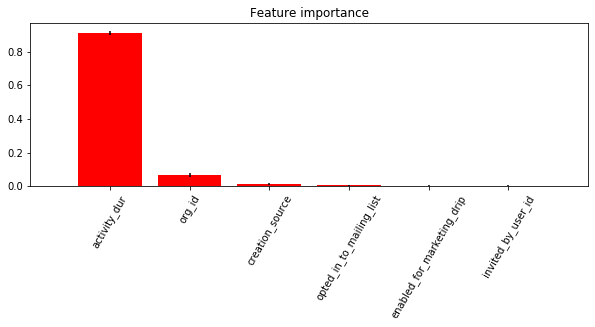

In [34]:
importances = rfc_cv.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_cv.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
f_indices = [data_x.columns[i] for i in indices]

plt.figure(figsize = (10,3))
plt.title("Feature importance")
plt.bar(range(data_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data_x.shape[1]), f_indices, rotation = 60)
plt.xlim([-1, data_x.shape[1]])
plt.show()

It seems straight-forward that activity duration would the most important feature since it would be directly related to the criterion we define for an 'adopted' user. So, let's remove it and see how the features fare.

In [35]:
data_x2 = users.drop(['adopted', 'activity_dur'], axis=1)

In [36]:
X2_train, X2_test, y2_train, y2_test = train_test_split(\
        data_x2, data_y, test_size=0.25, stratify=data_y, random_state=17)

In [37]:
rfc_cv2 = GridSearchCV(rfc , param_grid = hpar , cv = 5)
rfc_cv2.fit(X2_train, y2_train)

print(rfc_cv2.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_samples': 1, 'n_estimators': 50}


In [38]:
print(' Accuracy on training data : \n' , classification_report(y2_train, rfc_cv2.predict(X2_train), target_names=['non-adopted', 'adopted']))
print(' Accuracy on test data : \n' , classification_report(y2_test, rfc_cv2.predict(X2_test), target_names=['non-adopted', 'adopted']))

 Accuracy on training data : 
               precision    recall  f1-score   support

 non-adopted       0.86      1.00      0.93      7758
     adopted       0.00      0.00      0.00      1242

    accuracy                           0.86      9000
   macro avg       0.43      0.50      0.46      9000
weighted avg       0.74      0.86      0.80      9000

 Accuracy on test data : 
               precision    recall  f1-score   support

 non-adopted       0.86      1.00      0.93      2586
     adopted       0.00      0.00      0.00       414

    accuracy                           0.86      3000
   macro avg       0.43      0.50      0.46      3000
weighted avg       0.74      0.86      0.80      3000



C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


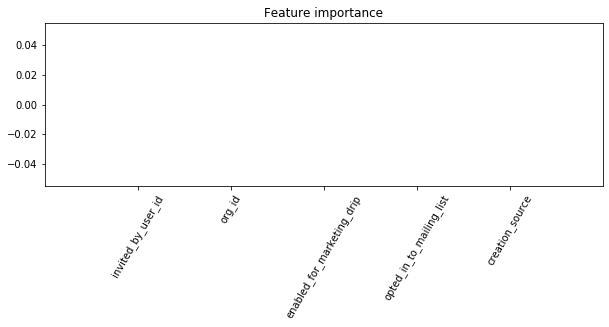

In [39]:
importances = rfc_cv2.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_cv2.best_estimator_.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
f_indices = [data_x2.columns[i] for i in indices]

plt.figure(figsize = (10,3))
plt.title("Feature importance")
plt.bar(range(data_x2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data_x2.shape[1]), f_indices, rotation = 60)
plt.xlim([-1, data_x2.shape[1]])
plt.show()

It seems that these 5 features (after removing activity duration) are not enough on their own to be good predictors of adoption. We should consider a different approach to feature engineering to come up with a good model. For example, we can try to extract any seasonal pattern in the adoption pattern from creation time.